# Predicting The Office episode ratings to advise NBC Universal on a reunion episode
#### Machine Learning in Python - Group Project 1
*Data Scientist Contractors: Luke Appleby, Josep Garcia-Reyero, Tom Birkbeck, Adam Dunajski*

In this report, we explore what makes a great episode of The Office, NBC Universal's widely-regarded situational comedy about the office life of a paper manufacturer. 

This is achieved through a machine learning model which predicts the rating of the episode based on a number of episode characteristics - such as whether the episode features a cold open, and how many spoken lines are in it. 

We use this model to give a reccomendation on episode features which will **maximise IMBD rating** for the episode.

The report is formatted in the style of an interactive workbook in which the client (NBC Universal) can step through cells of code interspersed with explanation of model choices and mathematical background.

### Table of Contents

0.  Predicting The Office episode ratings to advise NBC Universal on a reunion episode
1. Introduction    
    1.1 Model and conclusions overview/precis    
    1.2 Data sources used    
    1.3 General code setup       
2. Exploratory Data Analysis and Feature Engineering    
    2.1 Correlation exploration   
    2.2 Feature engineering and discussion
    2.3 Exploration of potential dimensionality reduction
    2.4 Paired characters feature exploration 
3. Model fitting and tuning    
    3.1 Selection of the Ridge Model  
    3.2 Fine Tuning the Model     
4. Discussion and Conclusions 
    4.1 Model Performance 
    4.2 Recommednations
5. References

## 1 Introduction
In recent years it has become popular for shows to have reunion episodes aired potentially boosting the market for online streaming of the older episodes. It is important to get these episodes right as failure to do so may taint viewers otherwise good memories of their favourite shows. In this report we aim to use machine learning methods to give informative recommendations on what a reunion episode of the TV show "The US Office" should include to achieve the highest possible IMDb rating. We had an initial data set with a variety of features such as number of lines and main characters. It also had the IMDb rating of each episode. The full feature space for **the_office.csv** (Source  https://pypi.org/project/schrutepy/) contains the following variables:

* season - The season that the episode appears in
* episode - The number of the episode within the season
* episode_name - The name of the episode
* director - The director(s) of the episode
* writer - The writer(s) of the episode
* imdb_rating - The IMDb rating of the episode 
* total_votes- The number of ratings of the episode on IMDb
* air_date - The date the episode originally aired on
* n_lines - The number of lines spoken
* n_directions - The number of stage directions 
* n_words - The number of words spoken
* n_speak_char - The number of characters with dialogue 
* main_chars - The main characters that feature in the episode

We also used an additional three data sets one containing all of Jim's pranks which are found in many episodes and are a trademark of the show and one contained data for which episodes had cold opens. Cold opens are when there is a short scene before the opening title sequence. Additionally we included data for which episodes were key in the development of Jim and Pam's relationship as this is a central plotline to the show. We also did some feature engineering to create the features 'cs' for calendar season and 'month' for the month of release of the episode. 

We fitted the data with a number of regression models and investigated the impact the features had on IMDb ratings. We tried linear regression Lasso and Ridge methods and we found that a Ridge regression model gave us the greatest predictive capabilities with Lasso giving similar results and the linear regression gave little predictive power. 

## 1.1 Model and conclusions overview/precis

After comparing a number of models, we found a ridge regression model was the best to fit to the data. It had an $R^2$ value of $0.4046$. This means that the features that we included account for approximately 40% of the variability of the IMDB rating that each episode received. Due to the large number of possible parameters that may or may not be measurable it is difficult to build a perfect predictive model of a TV episode without overfitting. A TV episode contains hundreds of design decisions in each frame, and all the data on these is simply not available. 

With that in mind, we make an important first conclusion: the average episode of the office achieved a rating of over 8.25, which is extremely high. In general, NBC already had a successful team and formula for producing good episodes, and this should be replicated as much as possible. 

However, our model did indicate that the following varibles correlated with IMDb rating in order of magnatude: 'writer', 'director', 'main_chars', 'n_words', 'pam_and_jim_key_episode', 'cs', 'n_directions', 'n_speak_chars', 'cold_open', 'jim_pranks'. From our analysis we make the following recomendations:


**To include in the episode**
* The director Greg Daniels
* The writer Paul Lieberstein 
* The characters Michael Scott, Jim, Kelly, Creed and Stanley
* Have the script contain a large number of words which may in fact mean that we have a longer episode
* Make the episode a key episode in Jim and Pam’s relationship (perhaps a pregnancy) 
* Release the episode in spring 
* Have a large number of directions 
* Have a large number of speaking characters
* Have the episode start with a cold open 
* Include some pranks from Jim 

**To avoid in episode**
* Do not have Paul Lieberstein as a director
* Do not have Charlie Grandy as a writer
* Do not have the character Erin feature much or at all in the episode 
* Do not release the episode in autumn 

Additionally we note that the episode should stick as closely as possible to the formula that has given the US Office consistently high ratings over its 9 seasons. Further we recommend that the chosen directors and writers should be given a degree of free reign to create an episode consistent with their own style and taste. Throughout this report we detail the methods used and decisions we made in order to fit our model to the data and from this model make informed recommendations for a reunion episode for the office.

## 1.2 Data sources
Our primary data source was the office episode ratings dataset the_office.csv (Evkaya, 2023).

We also explored the binary variable of whether or not the episode featured a cold-open, where the setting and premise of the episode is introduced in media res at the beginning of the episode, before the credits. This data was web-scraped from Dunderpedia: The Office Encyclopedia (Various authors, 2023a) and included in our dataset after an extensive cleaning process.

Furthermore, we explored two running themes of the episodes themselves: these are how many times Jim plays a prank in an episode, and whether or not the episode is contains key moments for the development of one of the series' key romantic relationships between Jim and Pam. The first of these was also sourced by web-scrapoing Dunderpedia: The Office Encyclopedia and subjecting the data to an extensive cleaning process (Various authors, 2023b), whilst the second was scraped and cleaned from a CinemaBlend article (West, 2020).

In total, this gave us four data sources:
* Initial dataset
* Dunderpedia article on cold opens
* Dunderpedia article on Jim's pranks
* CinemaBlend article on Jim and Pam's relationship.

## 1.3 General Setup
The following cell makes necessary package imports and sets some parameters for plotting.

In [80]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

import warnings
warnings.filterwarnings('ignore')

The next four cells read and join the data from our four sources. We start with the_office.csv as as the base, and treat other data as additional, cleaning, transforming and appending it.

In [81]:
# Read CSV file data
data = pd.read_csv("the_office.csv")
# Since total_votes is a dependent variable we immediately drop it 
data = data.drop('total_votes', axis=1)
data_explore = data.copy()

In [82]:
with open('MLP_cold_opens.txt', 'r') as file:
    new_data = file.read().replace('\n', '')

    
# Splitting the data up so we can see which episode has a cold open 
x = new_data.split(")")
hots = []
for i in range(len(x)):
    if x[i][0:4] == 'None':
        hots.append(x[i][7:-1])
    elif x[i][0:8] == 'Season 1' and x[i][8:12] == 'None':
        hots.append(x[i][14:])
    elif x[i][0:6] == 'Season' and x[i][8:12] == 'None':
        hots.append(x[i][15:-1])

hots_df = pd.DataFrame (hots, columns = ['episode_name'])
hots_df['cold_open'] = np.zeros(12).astype(int)

# Renaming so it is consistent with our existing data 
hots_df = hots_df.replace(to_replace = 'Weight Loss', value = 'Weight Loss (Parts 1&2)')
data_ = pd.merge(data, hots_df, on='episode_name', how='left')
data_['cold_open'] = data_['cold_open'].fillna(1)

data_.loc[data_['cold_open'] == 1]
data = data_

In [83]:
# Reading text file with cold opens data 
with open('MLP_jim_pranks.txt', 'r') as file:
    pranks_str = file.read().replace('\n', '')

# Data cleaning and pre-processing 
x0 = pranks_str.split('(')
j = 0
for i in x0:
    x0[j] = i.split(')')
    j+=1
j = 0
for i in x0:
    x0[j] = i[0]
    j +=1
for i in range(len(x0)):
    x0[i] = x0[i][1:-1]


names = data['episode_name']

names = names.replace(to_replace = 'E-Mail Surveilance', value = 'Email Surveillance')
names = names.replace(to_replace = 'A Benihana Christmas ', value = 'A Benihana Christmas')
names = names.replace(to_replace = 'The Job ', value = 'The Job', regex = True)
names = names.replace(to_replace = 'Launch Party ', value = 'Launch Party', regex = True)
names = names.replace(to_replace = 'Goodbye, Toby ', value = 'Goodbye Toby', regex = True)
names = names.replace(to_replace = 'Niagara ', value = 'Niagara', regex = True)
names = names.replace(to_replace = 'The Cover', value = 'The Cover-Up', regex = True)
names = names.replace(to_replace = 'Classy Christmas ', value = 'Classy Christmas', regex = True)
names = names.replace(to_replace = 'Dwight K. Schrute, (Acting) Manager', value = 'Dwight K. Schrute,')
names = np.array(names)

j = 0
for i in names:
    if i[-11:] == '(Parts 1&2)':
        names[j] = i[:-11]
    elif i[-8:] == '(Part 1)' or i[-8:] == '(Part 2)':
        names[j] = i[:-8]
    j +=1
        
pranks = []
for i in names:
    #print(x0.count(i))
    pranks.append(x0.count(i))
#     a += x0.count(i)

data['jim_pranks'] = pranks

data
data_explore = data.copy()

In [85]:
# Reading text file with Jim and Pam data 
with open('jim_and_pam_key_episodes.txt', 'r') as file:
    text = file.read()
    
start = 0
pam_jim_episodes = []

while True:
    start = text.find('(', start) + 1
    if start == 0:
        break
        
    end = text.find(')', start)
    between_brackets = text[start:end]
    
    if any(char.isdigit() for char in between_brackets):
        season = int(between_brackets[1])
        after_E_string = between_brackets[between_brackets.find('E')+1:]
        
        if '/' in after_E_string:
            pam_jim_episodes.append([season, int(after_E_string[:after_E_string.find('/')])])
            pam_jim_episodes.append([season, int(after_E_string[after_E_string.find('/')+1:])])
        
        else:
            pam_jim_episodes.append([season, int(after_E_string)])
        
    start = end + 1
    
    
def is_jim_and_pam_key_episode(row, key_episodes):
    season, episode = row['season'], row['episode']
    return int([season, episode] in key_episodes)

data_explore['pam_and_jim_key_episode'] = data_explore.apply(
    lambda row: is_jim_and_pam_key_episode(row, pam_jim_episodes), axis=1
)

Since the varibales 'season' and 'episode' are out of our control we drop these from our dataset 

In [86]:
# We drop the variables season and episode
data = data.drop('season', axis=1)
data = data.drop('episode', axis=1)

data_explore = data_explore.drop('season', axis=1)
data_explore = data_explore.drop('episode', axis=1)

## 2. Exploratory Data Analysis and Feature Engineering

## 2.1 Correlation exploration
In the cell below, we show the data frame created from our four sources without any modification, alongside summary statistics. Additionally, we check for NA and duplicated values in the data, finding none - an important step in veryifying the data we collected.  

In [67]:
print ("Columns in the df are:")
print (data_explore.columns.tolist(), "\n")

dup_num = pd.DataFrame(data_explore).duplicated().sum()
print("There are {} duplicated values in the data".format(dup_num))

na_num = data_explore.isna().sum().sum()
print(f"There are {na_num} Na values in the data")

data_explore.describe()

Columns in the df are:
['episode_name', 'director', 'writer', 'imdb_rating', 'air_date', 'n_lines', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode'] 

There are 0 duplicated values in the data
There are 0 Na values in the data


,imdb_rating,n_lines,n_directions,n_words,n_speak_char,cold_open,jim_pranks,pam_and_jim_key_episode
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,8.250538,296.397849,50.150538,3053.510753,20.693548,0.935484,0.521505,0.231183
std,0.535168,81.998568,23.941797,799.271717,5.092407,0.246333,0.901692,0.422727
min,6.700000,131.000000,11.000000,1098.000000,12.000000,0.000000,0.000000,0.000000
25%,7.900000,255.250000,34.000000,2670.250000,17.000000,1.000000,0.000000,0.000000
50%,8.200000,281.000000,46.000000,2872.500000,20.000000,1.000000,0.000000,0.000000
75%,8.600000,314.500000,60.000000,3141.000000,23.000000,1.000000,1.000000,0.000000
max,9.700000,625.000000,166.000000,6076.000000,54.000000,1.000000,8.000000,1.000000


Our summary statistics show us a few important summary points:
* There are 186 episodes in the dataset.
* The mean IMDB rating across the series was 8.25.
* The average number of Jim pranks per episode is 0.5, with a maximum of 8 in one.

In the cell below, we create a correlation heatmap between the current columns of a dataset, to give some understanding of the data. We are looking for variables with a high correlation with each other (as they may not both add a lot of value to the model) and the correlation of variables with IMDB ratings.

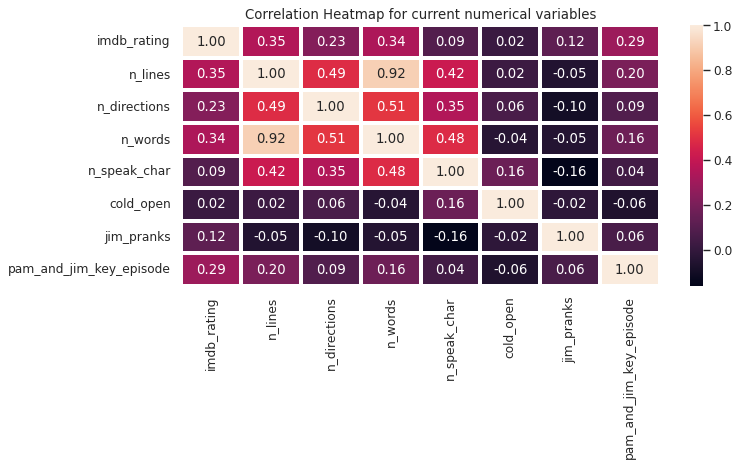

In [68]:
# Plotting heatmap
sns.set(rc={'figure.figsize': (10, 6)})
sns.heatmap(data_explore.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap for current numerical variables")
plt.tight_layout()
plt.show()

We see that the number of lines and number of words features are highly correlated so we will chose to drop 'n_lines' as including both would be redundant. 

In [69]:
data = data.drop('n_lines', axis=1)
data_explore = data_explore.drop('n_lines', axis=1)

## 2.2 Feature engineering and justification
This section contains the feature engineering for the model, including columns added and dropped and the justifications as to why. 

We will first drop the episode name and episode number features because they are not relevant to the model.

In [70]:
data_explore = data_explore.drop("episode_name", axis=1)
print (data_explore.columns.tolist())

['director', 'writer', 'imdb_rating', 'air_date', 'n_directions', 'n_words', 'n_speak_char', 'main_chars', 'cold_open', 'jim_pranks', 'pam_and_jim_key_episode']


Next, we will use the variable "air_date" to create two new categorical variable features: "calendar_season", being the season (autumn, winter, spring, summer) when the episode was aired; and "air_month" being the month the episode aired. After this we drop "air_date".

In [71]:
# convert the 'dates' column to datetime format
data_explore['air_date'] = pd.to_datetime(data_explore['air_date'])

# create a new categorical column 'calendar_season' by assigning a category "winter", 
# "spring", "summer", "autumn" depending on the air-month.
data_explore['calendar_season'] = pd.cut(
    data_explore['air_date'].dt.month, 
    [0, 3, 6, 9, 12], 
    labels=['winter', 'spring', 'summer', 'autumn']
)

# convert calender season to string column rather than categorical column.
data_explore['calendar_season'] = data_explore['calendar_season'].astype(str)

# Create month column.
data_explore['month'] = data_explore['air_date'].dt.month

In [72]:
data_explore = data_explore.drop("air_date", axis=1)
data_explore.head(5)

,director,writer,imdb_rating,n_directions,n_words,n_speak_char,main_chars,cold_open,jim_pranks,pam_and_jim_key_episode,calendar_season,month
0,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...,0.0,3,1,winter,3
1,Ken Kwapis,B.J. Novak,8.3,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...,0.0,0,0,winter,3
2,Ken Whittingham,Paul Lieberstein,7.9,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,2,0,spring,4
3,Bryan Gordon,Michael Schur,8.1,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,0.0,1,0,spring,4
4,Greg Daniels,Greg Daniels,8.4,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...,0.0,0,0,spring,4


Our current data contains columns such as main_chars which have a number of non-numerical and non-continuous variables. We need to split these into categorical variables. For example, if an episode had Michael in it, we'd want to be able to quickly access a column called mc_michael and if it was = 1, we'd know he was in the episode. 

The following code defines and deploys a one hot encoder that assigns a binary attribute per category for the categorical variables ("director, "writer", "calendar_season" and "main_chars"):

In [ ]:
def OneHot_encoder(df, cat_variable):
    oneHot_df = df.copy()
    variable_initials = ''.join([word[0] for word in cat_variable.split("_")])

    
    unique_chars = set(';'.join(oneHot_df[cat_variable]).split(';'))

    # Create binary attributes for each unique character
    for char in unique_chars:
        oneHot_df[variable_initials+"_"+char] = oneHot_df[cat_variable].apply(lambda x: 1 if char in x else 0)
    
    
    # Drop the original main_chars column
    oneHot_df = oneHot_df.drop(columns=[cat_variable])
    
    return oneHot_df


cat_variables = ['director', 'writer', 'main_chars', 'calendar_season']

for cat_variable in cat_variables:
    data_explore = OneHot_encoder(data_explore, cat_variable)

data_explore.head(5)

By inspection we realised that there are some repeated directors where in some data entries the name of the director is spelled wrong. The specific cases were:

 - Charles McDougall (correct name) and Charles McDougal
 - Claire Scanlon (correct name) and Claire Scanlong 
 - Greg Daniels (correct name) and Greg Daneils
 - Ken Whittingham (correct name) and Ken Wittingham 
 - Paul Lieberstein (correct name) and Paul Lieerstein
 
The following code removes columns with the wrong name, where we will put a 1 in the correct name column if the incorrect one had a 1 and the correct one didn't.

In [ ]:
correct_names = ['d_Charles McDougall','d_Claire Scanlon','d_Greg Daniels', 'd_Ken Whittingham', 'd_Paul Lieberstein']
wrong_names = ['d_Charles McDougal','d_Claire Scanlong','d_Greg Daneils', 'd_Ken Wittingham', 'd_Paul Lieerstein']

for i, correct_name in enumerate(correct_names):
    data_explore.loc[data_explore[wrong_names[i]] == 1, correct_name] = 1
    data_explore = data_explore.drop(wrong_names[i], axis=1)
    
data_explore.head(5)

Having defined our data, we now need to explore the predictive power of each piece of data in creating a good episode with high imdb ratings. The following plot gives the correlation between each variable individually and the imdb rating. 

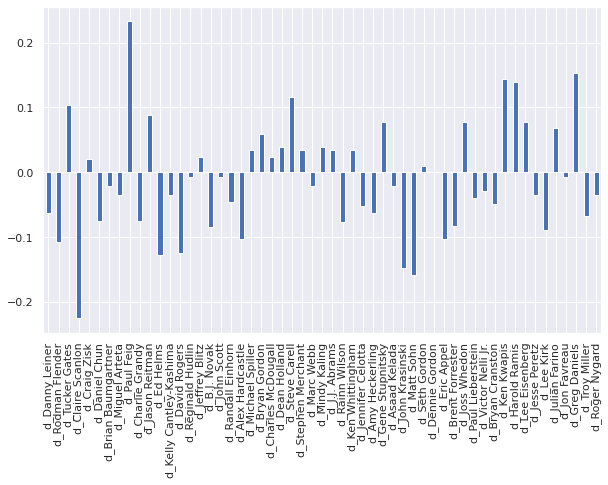

<Figure size 720x432 with 0 Axes>

In [39]:
# Exploring correlation between IMDb and directors
columns = list(data_explore.columns)
d_list = [columns[i] for i in range(len(columns)) if columns[i][:2] == "d_"]
corr_mat_d = data_explore[d_list + ["imdb_rating"]].corr()["imdb_rating"]
corr_mat_d = corr_mat_d[:-1]
print()
corr_mat_d.plot(kind='bar')
plt.xticks(rotation ='vertical')
plt.show()
plt.tight_layout()

## 2.3 Exploration of potential dimensionality reduction

To reduce the dimenionsionality of our data and avoid overfitting, the following code cells look at directors, writers and main characters in the dataset with a greater than 0.1 absolute correlation value with IMDB rating. 

In our model fine tuning, this was important to prevent overfitting and to reduce dimensionality, but is only presented here as EDA.

In [40]:
corr_mat_d_siginificant = corr_mat_d[abs(corr_mat_d) > 0.1]
corr_mat_d_siginificant

d_Rodman Flender    -0.107541
d_Tucker Gates       0.104012
d_Claire Scanlon    -0.224743
d_Paul Feig          0.232619
d_Ed Helms          -0.127075
d_David Rogers      -0.124627
d_Alex Hardcastle   -0.103387
d_Steve Carell       0.115819
d_John Krasinski    -0.148062
d_Matt Sohn         -0.159096
d_Eric Appel        -0.103387
d_Ken Kwapis         0.143246
d_Harold Ramis       0.138732
d_Greg Daniels       0.153229
Name: imdb_rating, dtype: float64

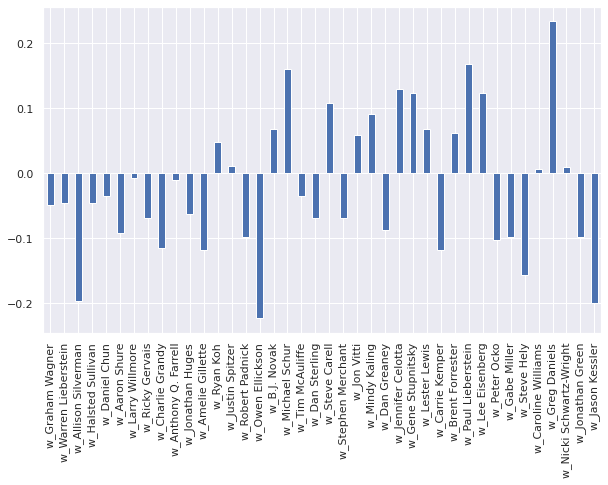

<Figure size 720x432 with 0 Axes>

In [41]:
# Exploring correlation between IMDb and directors
w_list = [columns[i] for i in range(len(columns)) if columns[i][:2] == "w_"]
corr_mat_w = data_explore[w_list + ["imdb_rating"]].corr()["imdb_rating"]
corr_mat_w = corr_mat_w[:-1]
print()
corr_mat_w.plot(kind='bar')
plt.xticks(rotation ='vertical')
plt.show()
plt.tight_layout()

In [42]:
# Extracting potentially significant writers
corr_mat_w_siginificant = corr_mat_w[abs(corr_mat_w) > 0.1]
corr_mat_w_siginificant

w_Allison Silverman   -0.196041
w_Charlie Grandy      -0.114410
w_Amelie Gillette     -0.117308
w_Owen Ellickson      -0.222360
w_Michael Schur        0.160538
w_Steve Carell         0.107331
w_Jennifer Celotta     0.129994
w_Gene Stupnitsky      0.123633
w_Carrie Kemper       -0.118199
w_Paul Lieberstein     0.168538
w_Lee Eisenberg        0.123633
w_Peter Ocko          -0.103387
w_Steve Hely          -0.156059
w_Greg Daniels         0.233452
w_Jason Kessler       -0.199813
Name: imdb_rating, dtype: float64

## 2.4 Paired-characters feature exploration

In this section, we explore the effect of character pairings. For example, Jim and Dwight had a number of running jokes and gags which may have affected IMDB rating of episodes that they both featured in. 

This cell creates lists of main character names, and then adds main character pairings to a data exploration frame. The purpose of this analysis is to determine whether some characters are better on screen with others. 

In [43]:
# Exploring the correlation of character pairs agains IMDb
mc_list = [columns[i] for i in range(len(columns)) if columns[i][:3] == "mc_"]
n = len(mc_list)
pairnames = []
data_explore_2 = data_explore.copy()
for i in range(n-1):
    for j in range(i+1,n):
        pairname = "pair_" + mc_list[i][3:] + "_"+ mc_list[j][3:]
        pairnames.append(pairname)
        data_explore_2[pairname] = ((data_explore_2[mc_list[i]] + data_explore_2[mc_list[j]])//2)

In [44]:
corr_mat_p = data_explore_2.corr()["imdb_rating"]

corr_array_p = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1,n):
        pairname = "pair_" + mc_list[i][3:] + "_"+ mc_list[j][3:]
        corr_array_p[i][j] = corr_mat_p[pairname]
        corr_array_p[j][i] = corr_mat_p[pairname]
    corr_array_p[i][i] = corr_mat_p[mc_list[i]]

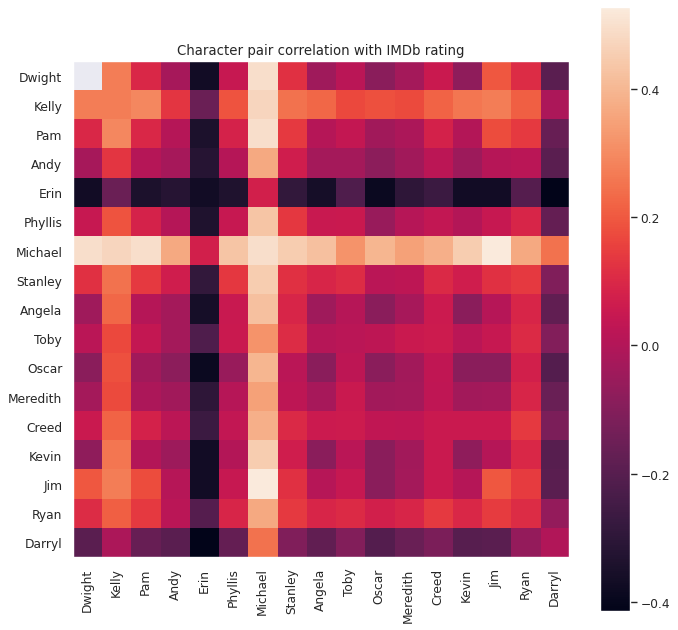

In [88]:
fig, axes = plt.subplots(figsize = (10,10), ncols = 1)

mc_names = [mc_name[3:] for mc_name in mc_list]
plt.grid(b=False)
plt.imshow(corr_array_p)
plt.colorbar()
plt.xticks(range(n), mc_names, rotation ='vertical')
plt.yticks(range(n), mc_names)
plt.title('Character pair correlation with IMDb rating')
plt.show()

We note the positive impact of Michael and Kelly with all other characters and the negative impact of Erin and Darryl. Dwight's correlation with himself is so high because he is in every episode: this is an important observation as we will need to drop Dwight from the final model, his presence in an epsiode cannot be compared with episodes he isn't in so we shouldn't include it in the model.

## 3. Model Fitting and Tuning

In this section, we fit our model to the data and fine-tune it based on the EDA conducted in section 2. We tested a number of models and eventually settled on on a ridge regression model, preliminary results for our other models are noted below.

The following cell imports necessary SciKitLearn packages and sets up get_coefs functions. 

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return m.coef_

def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(11, 5.5))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle(r"Model (MSE, RMSE, $R^2$) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr


# Having done all the data exploration and feature engineering, we now set our starting dataframe to the 
# engineered dataframe.
data = data_explore

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('imdb_rating', axis=1), data['imdb_rating'], 
    test_size=0.3, random_state=42
)

### Selcection of the Ridge model

From testing out Ridge, Lasso and Linear regression models we found that Ridge gave us the best performance so we opted to choose it for fine tuning. 

In [47]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

# Applying a gridsearch procedure to find the optimal alpha value
alphas = np.linspace(0, 200, num=200)
gs_ridg3 = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs_ridg3.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([  0.        ,   1.00502513,   2.01005025,   3.01507538,
         4.0201005 ,   5.02512563,   6.03015075,   7.03517588,
         8.04020101,   9.04522613,  10.05025126,  11.05527638,
        12.06030151,  13.06532663,  14.07035176,  15.0753768...
       172.86432161, 173.86934673, 174.87437186, 175.87939698,
       176.88442211, 177.88944724, 178.89447236, 179.89949749,
       180.90452261, 181.90954774, 182.91457286, 183.91959799,
       184.92462312, 185.92964824, 186.93467337, 187.93969849,
       188.94472362, 189.94974874, 190.95477387, 191.95979899,
       192.96482412, 193.96984925, 194.97487437, 195.9798995 ,
       196.98492462, 197.98994975, 198.99497487, 200.        ])},
             scoring='neg_root_mean_squared_error')

In [50]:
print(gs_ridg3.best_params_)

{'ridge__alpha': 145.7286432160804}


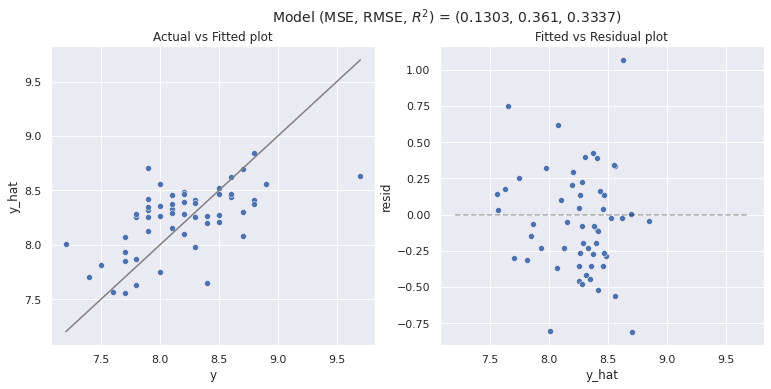

In [51]:
model_pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=145.72))
])


# Fitting the model
model_pipeline_ridge.fit(X_train, y_train)

mse, rmse, rsqr = model_fit(model_pipeline_ridge, X_test, y_test, plot=True)

## Fine Tuning the model

In this section we will drop features from our model in order to avoid overfitting. Fist of all, we will investigate how many times each director appears in the data, and we will fit a linear regression (against IMDb rating) for each and measure R^2 both for the train data and test data. We will also carry out the same process for writers and main characters.



In [52]:
directors = X_train.filter(regex='^d_').columns.values
writers = X_train.filter(regex='^w_').columns.values
main_characters = X_train.filter(regex='^mc_').columns.values
rest_of_features = [var for var in X_train.columns.values 
                if var not in np.concatenate((directors, writers, main_characters), axis=0)]

def get_features_rsqr(features, label):
    features_frequencies = data[features].sum(axis=0)
    rsqr_train_all = []
    rsqr_test_all = []
    
    # Looping through each feature and fit a simple linear regression
    for col in features:
        X = np.c_[X_train[col]]
        m = LinearRegression(fit_intercept=True).fit(X, y_train)
        mse, rmse, rsqr_train = model_fit(m, X, y_train)
        mse, rmse, rsqr_test = model_fit(m, np.c_[X_test[col]], y_test)

        rsqr_train_all.append(rsqr_train)
        rsqr_test_all.append(rsqr_test)
    
    # Print out table
    df = pd.DataFrame({label: features, 'Frequency': features_frequencies, 
                       'R^2 train': rsqr_train_all, 'R^2 test': rsqr_test_all})
    df = df.sort_values(by=['R^2 train'], ascending=False)
    return df.reset_index(drop=True)
    

get_features_rsqr(directors, 'Directors').head(10)

,Directors,Frequency,R^2 train,R^2 test
0,d_Claire Scanlon,2,0.066846,-0.044416
1,d_Paul Feig,14,0.038677,0.079539
2,d_John Krasinski,3,0.030056,-0.041402
3,d_Harold Ramis,4,0.022449,-0.018241
4,d_Ed Helms,2,0.022007,-0.037281
5,d_Greg Daniels,15,0.019921,0.009524
6,d_Steve Carell,3,0.015557,-0.020942
7,d_Eric Appel,1,0.014403,-0.033435
8,d_Alex Hardcastle,1,0.014403,-0.033435
9,d_B.J. Novak,5,0.013737,-0.053040


In [53]:
get_features_rsqr(writers, 'Writers').head(10)

,Writers,Frequency,R^2 train,R^2 test
0,w_Owen Ellickson,4,0.066846,-0.089808
1,w_Jason Kessler,1,0.052296,-0.038073
2,w_Paul Lieberstein,16,0.047219,-0.101873
3,w_Steve Hely,3,0.033270,-0.042130
4,w_Greg Daniels,12,0.028189,0.110828
5,w_Lee Eisenberg,15,0.024714,-0.067359
6,w_Gene Stupnitsky,15,0.024714,-0.067359
7,w_Jon Vitti,2,0.020706,-0.165538
8,w_Jennifer Celotta,11,0.018910,-0.023061
9,w_Carrie Kemper,4,0.018858,-0.044368


We can see that both directors and writers correlate very poorly with IMDb rating, since in both cases all the $R^2$ values are very small, not exceeding 0.06. We also notice that many of them take part in very few episodes, indicating that they are most likely not relevant features. Therefore, we have decided to drop all the directors and writers that appear in 5 episodes or less.

In [54]:
data_tuning = data.copy()

# Getting df with frequencies of each director and writer.
frequencies = data_tuning[list(writers) + list(directors)].apply(pd.Series.value_counts)
# Getting the ones we will drop
to_drop = frequencies.columns[frequencies.loc[1] <= 5]
# Dropping them.
data_tuning = data_tuning.drop(to_drop, axis=1)

In [55]:
main_chars_stats = get_features_rsqr(main_characters, 'Main characters')
main_chars_stats

,Main characters,Frequency,R^2 train,R^2 test
0,mc_Michael,137,0.244101,0.233410
1,mc_Erin,98,0.140186,0.099177
2,mc_Kelly,142,0.072594,0.047324
3,mc_Jim,185,0.052296,-0.038073
4,mc_Darryl,105,0.045861,-0.028430
5,mc_Stanley,165,0.008692,0.004926
6,mc_Ryan,139,0.007197,0.002627
7,mc_Creed,131,0.006404,-0.043715
8,mc_Oscar,164,0.005232,-0.015092
9,mc_Kevin,180,0.005082,-0.021952


In main characters on the other hand we see that Dwight appears in all the episodes, which thus leads to an $R^2$ of 0. Therefore, we will drop Dwight, and in our recommendations we will say that he should be included. Additionally, we see that in this case we two $R^2$ scores in train that are significant, 0.24 for Michael and 0.14 for Erin, but the other onces are once again very small. In order to decrease overfitting, we have decided to only keep the characters with the 10 biggest $R^2$.

In [56]:
# Dropping Dwigth.
data_tuning = data_tuning.drop('mc_Dwight', axis=1)


# Getiting the the characters not in the top 10 and dropping them.
bottom_characters = main_chars_stats["Main characters"].values[11:-1]
data_tuning = data_tuning.drop(bottom_characters, axis=1)


We now fit the model again with the new set of features.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    data_tuning.drop('imdb_rating', axis=1), data_tuning['imdb_rating'], 
    test_size=0.3, random_state=42
)

# Applying a gridsearch procedure to find the optimal alpha value
alphas = np.linspace(0, 100, num=200)
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([  0.        ,   0.50251256,   1.00502513,   1.50753769,
         2.01005025,   2.51256281,   3.01507538,   3.51758794,
         4.0201005 ,   4.52261307,   5.02512563,   5.52763819,
         6.03015075,   6.53266332,   7.03517588,   7.53768844,
         8.04...
        86.4321608 ,  86.93467337,  87.43718593,  87.93969849,
        88.44221106,  88.94472362,  89.44723618,  89.94974874,
        90.45226131,  90.95477387,  91.45728643,  91.95979899,
        92.46231156,  92.96482412,  93.46733668,  93.96984925,
        94.47236181,  94.97487437,  95.47738693,  95.9798995 ,
        96.48241206,  96.98492462,  97.48743719,  97.98994975,
        98.49246231,  98.99497487,  99.49748744, 100.        ])},
             scoring='neg_root_mean_squared_error')

In [58]:
print(gs.best_params_)

{'ridge__alpha': 74.87437185929647}


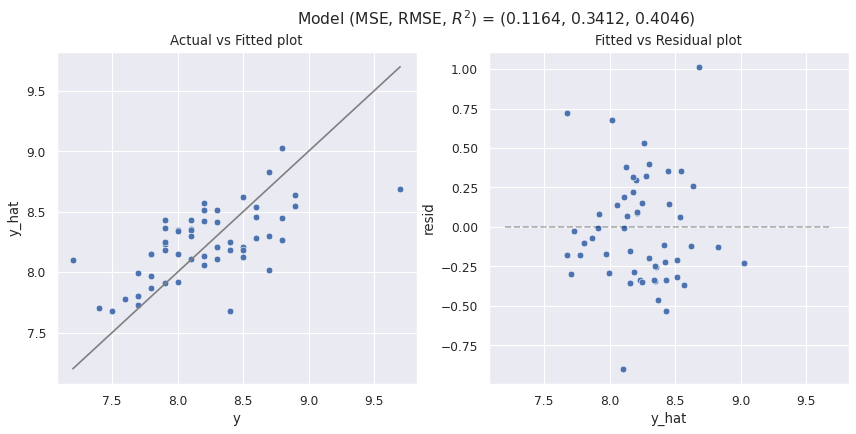

In [89]:
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=74.87))
])


# Fitting the model
final_model.fit(X_train, y_train)

mse, rmse, rsqr = model_fit(final_model, X_test, y_test, plot=True)

## 4. Discussion and Conclusions


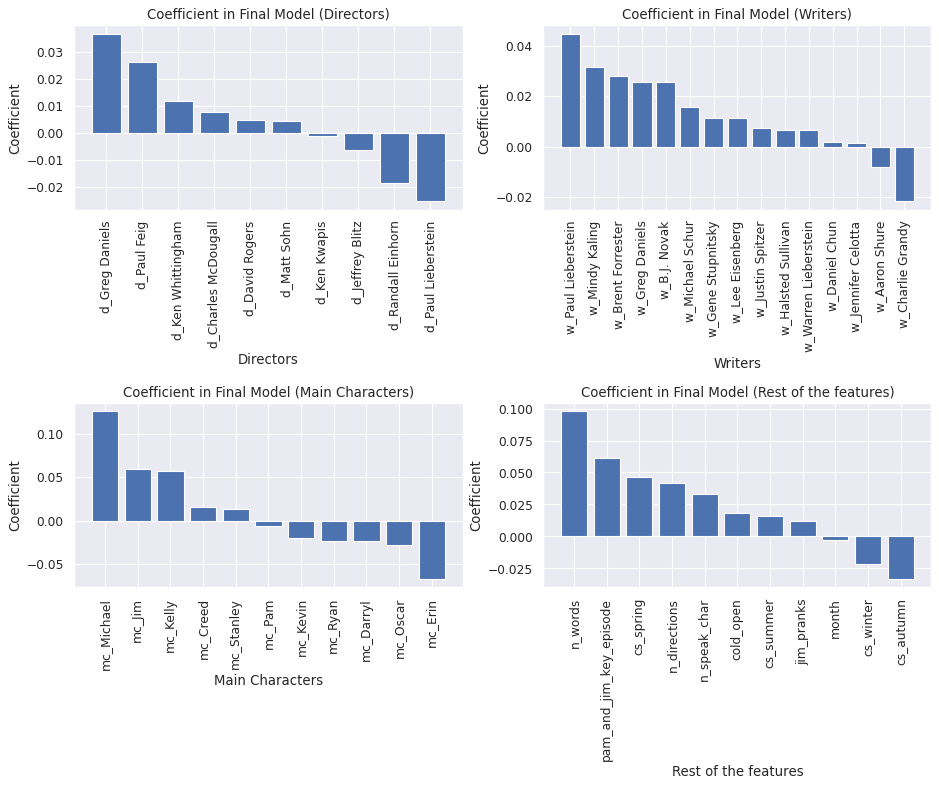

In [74]:
# Getting the new reduced number of directors, writers and main characters
directors = X_train.filter(regex='^d_').columns.values
writers = X_train.filter(regex='^w_').columns.values
main_characters = X_train.filter(regex='^mc_').columns.values

def plot_features_coef_magnitude_for_given_model(m, features, label, ax):
    # Getting the coefficients from the model and selecting subset
    # corresponding to features.
    coefs_series = pd.Series(get_coefs(m), index=X_train.columns)
    coefs_features = coefs_series.loc[features]
    
    # Sorting coefficients
    sorted_coef = coefs_features.sort_values(ascending=False)

    # Plotting.
    ax.bar(sorted_coef.index, sorted_coef.values)
    ax.set_xticklabels(sorted_coef.index, rotation=90)
    ax.set_xlabel(label)
    ax.set_ylabel('Coefficient')
    ax.set_title('Coefficient in Final Model ({})'.format(label))


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_features_coef_magnitude_for_given_model(final_model, directors, "Directors", axs[0, 0])
plot_features_coef_magnitude_for_given_model(final_model, writers, "Writers", axs[0, 1])
plot_features_coef_magnitude_for_given_model(final_model, main_characters, "Main Characters", axs[1, 0])
plot_features_coef_magnitude_for_given_model(final_model, rest_of_features, "Rest of the features", axs[1, 1])

plt.tight_layout()
plt.show()

## 4.1 Model Performance 

After fine tuning the model and selecting certain features we achived an $R^2$ value of $0.4046$ which suggests that we our model accounts for about $40%$ of the variability in IMDb rating given our features. This means that a large degree of the variability is outwith out predictive capabilities so it is important to not overestate the importence of our results. Other factors such as actors performance and plot details may affect the IMDb rating more than the features we had in our data set. That being said this $R^2$ value is high enough for us to make meaningful suggestions to NBC Universal as to how the reunion episode should be made. The **RMSE** value for our final model was 0.3412 so on avergae our predicted IMDb ratings were this far from the true IMDb ratings that the episodes recieved. This indicated that our model predicts with a resonable level of accuracy given IMDb rating are on a scale from 0-10. Additionally we removed features such as 'total_votes' and 'season' which would be outiwith the control of producers meaning that the predictions we make are relevent for the production of a future episode. 

Below we plot the value of the coeficcients the model gives depending on various selctions of $\alpha$. In ection 3 we used a gridsearch method to find the optimal $\alpha$ value for our model. The $\alpha$ parameter is intended to punish models with large amounts of predictive features. These plots are included to shed some light on how this affects the model.

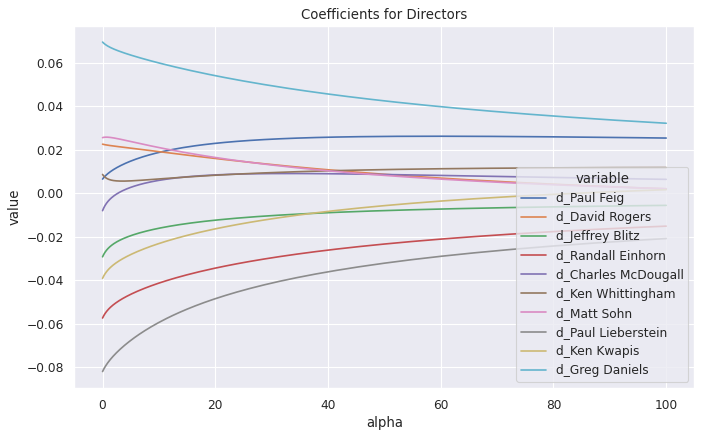

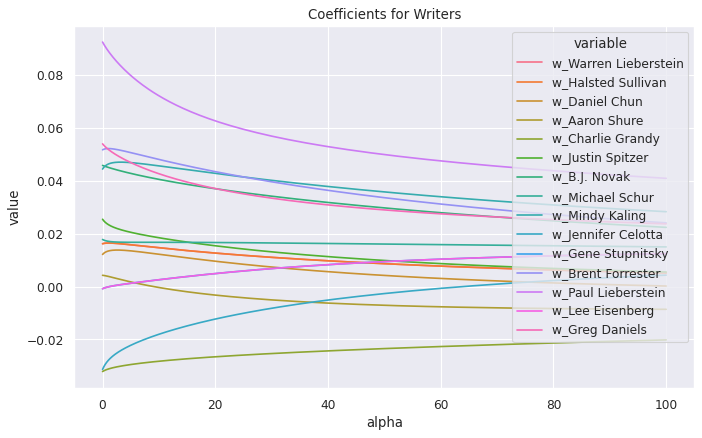

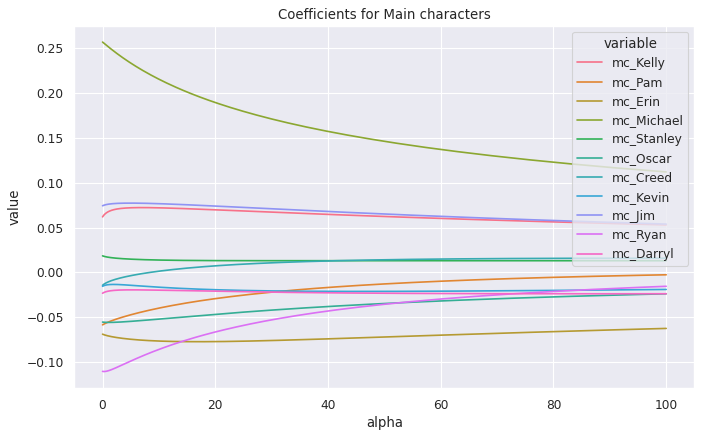

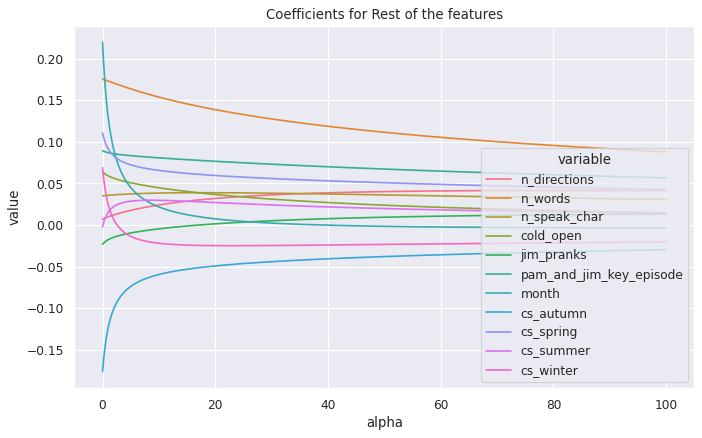

In [77]:
def coefs_vs_alpha(features, model_type, title):
    alphas = np.logspace(-2, 2, num=200) # from 10^-2 to 10^2
    
    # Arrays to store coefficients and rmses
    betas = [] 
    rmses = []

    for a in alphas:
        m = make_pipeline(
            StandardScaler(),
            model_type(alpha=a)
        ).fit(X_train, y_train)
        
        # Getting the coefficients for the specified features, and
        # getting rmses.
        coefs_series = pd.Series(get_coefs(m), index=X_train.columns)
        variables_coefs = coefs_series.loc[features]
        betas.append(variables_coefs)
        rmses.append(model_fit(m, X_test, y_test))
        
    # Createing DataFrame of coefficients and RMSEs
    res = pd.DataFrame(
        data=betas,
        columns=features,
    ).assign(
        alpha = alphas,
        rmse = rmses
    ).melt(
        id_vars = ('alpha', 'rmse')
    )
    
    # Plotting.
    sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients for "+title)
    plt.show()

    
coefs_vs_alpha(directors, Ridge, "Directors")
coefs_vs_alpha(writers, Ridge, "Writers")
coefs_vs_alpha(main_characters, Ridge, "Main characters")
coefs_vs_alpha(rest_of_features, Ridge, "Rest of the features")

## 4.2 Recomendations

From the plots above we can see that certain directors and writers gave significant improvements in the predicted IMDb rating of the episodes. Additionally certain characters and other features such as 'n_words' and 'pam_and_jim_key_episode' had positive correlations with IMDb rating. From these results we make the following recomendations:

**Directors: Greg Daniels or Paul Feig**

**Writers: Paul Liberstein, Mindy Kaling, Greg Daniels, or B. J. Novak**

**Minimal list of Main Characters: Dwight, Michael, Jim, Creed, Stanley, and Pam.**

**Characters to condisder not including: Erin.**

As per other Pam and Jim key episodes, the plot should atleast partially follow their relationship, maybe showing how this has progressed since the finale episode. That said, following our choice of directors and writers, these should be given creative freedom as our model shows that this has had a positive influence on the success of historic episodes. We do not provide advice on the number of lines and directions to be included, as we trust these will be determined by the choice of director and writer. However we refer them to our analysis that suggests a high number of lines and directions has a possitive impact on the rating. We leave it up to the writers and directors to decide on how to implement this advice into their visons for the reunion episode. Similarly our analysis suggests that the rating responds positively to the episode starting with a cold open, and containing Jim pranks, which is something we suggest the writers consider including.

Our analysis suggests that releasing the episode during spring, or failing this summer, may have a positive impact of the rating, whilst releasing in autumn may best be avoided.

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from


* Evkaya, Ozan. 2023. The Office CSV Data File, MATH11205: Machine Learning in Python, The University of Edinburgh.
* Various authors. 2023a. List of Cold Opens, Dunderpedia: The Office Encylopedia. Accessed on 08/03/2023. URL: https://theoffice.fandom.com/wiki/List_of_Cold_Opens
* Various authors. 2023b. List of Jim's Pranks, Dunderpedia: The Office Encylopedia. Accessed on 06/03/2023. URL: https://theoffice.fandom.com/wiki/List_of_Jim%27s_pranks
* West, Kelly. 2020. The Office: Jim Halpert And Pam Beesly's Relationship Told In 45 Episodes, CinemaBlend. Accessed on 05/03/2023. URL: https://www.cinemablend.com/television/2487769/the-office-jim-halpert-and-pam-beeslys-relationship-episode-playlist